In [189]:
import torch
import torch_geometric as pyg 
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import kornia


In [207]:
data_list = torch.load("/workspaces/masters_project/notebooks/simplified_gnn_task/harder_dataset.pt")


In [208]:
edge_list = []
for graphs in data_list:
    graph_1, graph_2 = graphs
    edge_list.append(torch.cat([graph_1.edge_attr, graph_2.edge_attr], dim=1))


In [209]:
#convert edge_list to a dataset
len(edge_list)
edge_tensor = torch.stack(edge_list, dim=0)
edge_tensor.shape


torch.Size([1000, 1225, 2])

In [210]:
#get a dataloader from the edge_tensor
edge_dataset = TensorDataset(edge_tensor)
edge_loader = DataLoader(edge_dataset, batch_size=32, shuffle=True)

In [211]:
class MyModel(torch.nn.Module):
    def __init__(self):
        #lets first try a ANN
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(1225, 128)
        self.fc2 = torch.nn.Linear(128, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        #upsample it
        self.fc4 = torch.nn.Linear(1, 32)
        self.fc5 = torch.nn.Linear(32, 128)
        self.fc6 = torch.nn.Linear(128, 1225)
        self.relu = torch.nn.ReLU()
    def forward(self, input):
        x = self.relu(self.fc1(input))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = torch.abs(x)
        return x

In [226]:
model1 = MyModel()
model2 = MyModel()

In [227]:
kl_loss = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = torch.optim.Adam(list(model1.parameters()) + list(model2.parameters()), lr=0.001)

In [229]:
loss_array = []
for epoch in range(20):
    for i in edge_loader:
        a, b = i[0][:, :, 0], i[0][:, :, 1]
        output_1 = model1(a)
        output_2 = model2(b)
        
        model_output_1 = output_1 * a
        model_output_2 = output_2 * b

        optimizer.zero_grad()
        #take the max of the two outputs
        max_1 = torch.max(model_output_1)
        max_2 = torch.max(model_output_2)
        max_val = torch.max(max_1, max_2)
        bins = torch.linspace(0, max_val.item(), 30)

        #hist1 = torch.histogram(model_output_1, bins=bins).hist.requires_grad_()
        #hist2 = torch.histogram(model_output_2, bins=bins).hist.requires_grad_()

        hist1 = kornia.enhance.histogram(model_output_1, bins=bins, bandwidth=torch.tensor(0.9))
        hist2 = kornia.enhance.histogram(model_output_2, bins=bins, bandwidth=torch.tensor(0.9))
        hist1 = torch.log(hist1)
        hist2 = torch.log(hist2)
        loss_val = kl_loss(hist1, hist2)
        loss_val.backward()
        loss_array.append(loss_val.item())
        optimizer.step()



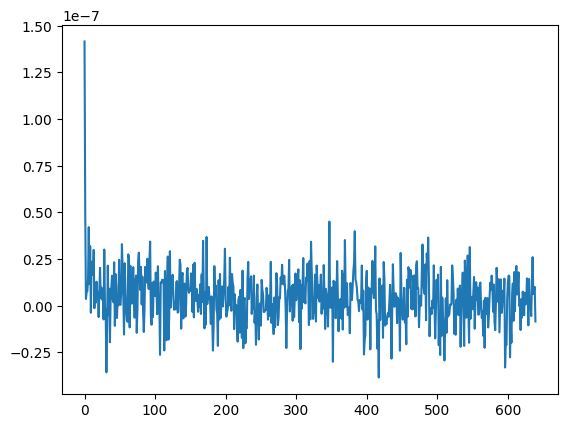

In [230]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(loss_array)


Lets see what these actually look like

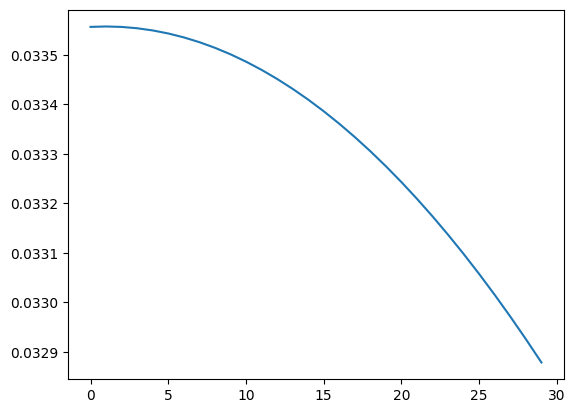

In [231]:
#plott the hist1 and hist2
#draw the axis plots 

plt.plot(torch.exp(hist1)[0].detach().numpy())


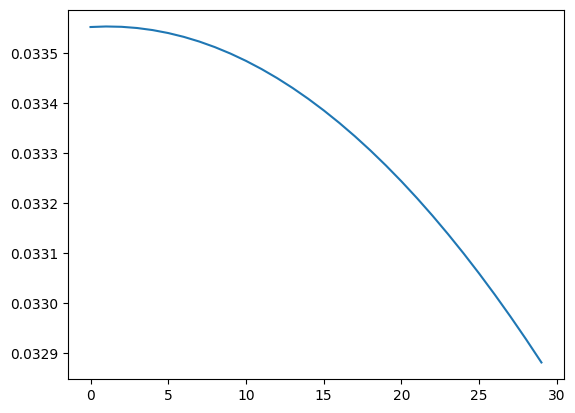

In [232]:
plt.plot(torch.exp(hist2)[0].detach().numpy())

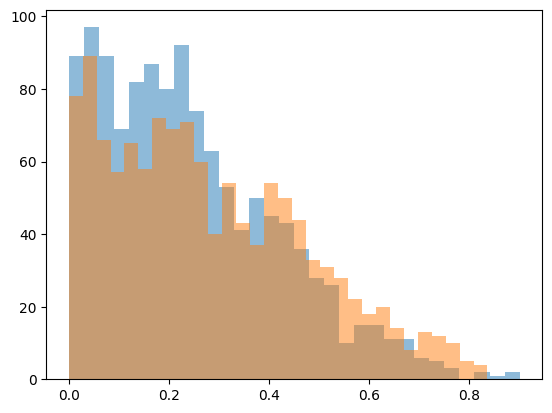

In [233]:
a_subset = a[0].detach().numpy()
b_subset = b[0].detach().numpy()
#plot the two histograms
plt.hist(a_subset, bins=30, alpha=0.5, label="a")
plt.hist(b_subset, bins=30, alpha=0.5, label="b")
plt.show()

(array([89., 97., 89., 69., 82., 87., 80., 92., 74., 63., 53., 41., 50.,
        45., 43., 36., 28., 26., 10., 15., 15., 11., 11.,  6.,  5.,  3.,
         0.,  2.,  1.,  2.]),
 array([4.81069088e-04, 3.05224545e-02, 6.05638400e-02, 9.06052217e-02,
        1.20646611e-01, 1.50687993e-01, 1.80729374e-01, 2.10770756e-01,
        2.40812153e-01, 2.70853519e-01, 3.00894916e-01, 3.30936313e-01,
        3.60977679e-01, 3.91019076e-01, 4.21060443e-01, 4.51101840e-01,
        4.81143236e-01, 5.11184633e-01, 5.41225970e-01, 5.71267366e-01,
        6.01308763e-01, 6.31350160e-01, 6.61391556e-01, 6.91432893e-01,
        7.21474290e-01, 7.51515687e-01, 7.81557083e-01, 8.11598480e-01,
        8.41639817e-01, 8.71681213e-01, 9.01722610e-01]),
 <BarContainer object of 30 artists>)

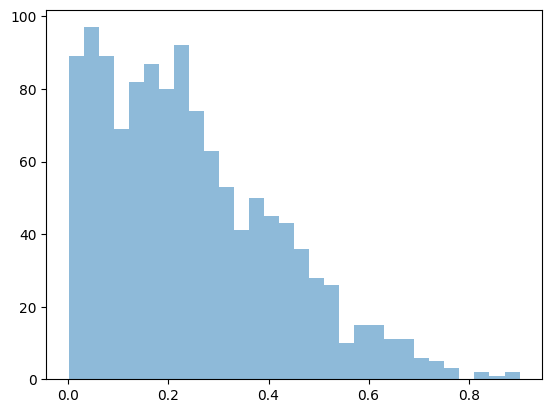

In [234]:
plt.hist(a_subset, bins=30, alpha=0.5, label="b")


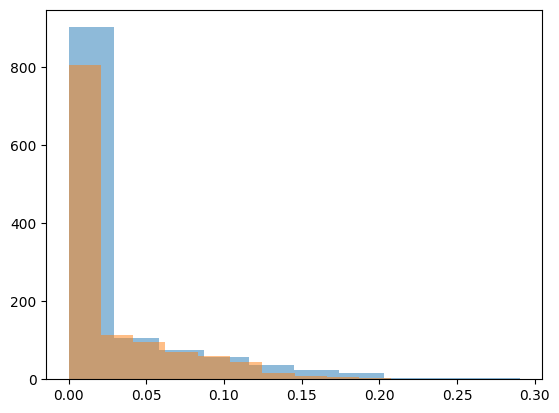

In [235]:
#plot the output 1 and 2
plt.hist(output_1[0].detach().numpy(), bins=10, alpha=0.5, label="output_1");
plt.hist(output_2[0].detach().numpy(), bins=10, alpha=0.5, label="output_2");